In [1]:
pip install chefboost

Importando bibliotecas

In [188]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from chefboost import Chefboost as chef
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import RandomOverSampler
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd

Abrindo arquivo CSV

In [189]:
# Função para calcular a entropia de um conjunto de rótulos de classe
def entropy(class_labels):
    unique_classes, class_counts = np.unique(class_labels, return_counts=True)
    total_samples = len(class_labels)
    entropy_value = -np.sum((class_counts / total_samples) * np.log2(class_counts / total_samples))
    return entropy_value

In [190]:
# Função para calcular o ganho de informação de um atributo em relação à classe
def information_gain(class_labels, attribute_values):
    original_entropy = entropy(class_labels)
    total_samples = len(class_labels)

    weighted_entropy = 0
    for value in np.unique(attribute_values):
        subset_indices = np.where(attribute_values == value)[0]
        subset_class_labels = class_labels[subset_indices]
        subset_weight = len(subset_class_labels) / total_samples
        weighted_entropy += subset_weight * entropy(subset_class_labels)

    gain = original_entropy - weighted_entropy
    return gain

In [192]:
base = pd.read_csv('https://raw.githubusercontent.com/Gustavolorenzz/IA/main/Bases/student-por.csv', sep=';')
base

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,MS,F,19,R,GT3,T,2,3,services,other,...,5,4,2,1,2,5,4,10,11,10
645,MS,F,18,U,LE3,T,3,1,teacher,services,...,4,3,4,1,1,1,4,15,15,16
646,MS,F,18,U,GT3,T,1,1,other,other,...,1,1,1,1,1,5,6,11,12,9
647,MS,M,17,U,LE3,T,3,1,services,services,...,2,4,5,3,4,2,6,10,10,10


In [193]:
# Suponha que a coluna 'approved' contenha os rótulos da classe alvo
class_labels = base['G3']

# Calcule o ganho de informação para cada atributo
attribute_gains = {}
for column in base.columns[:-1]:  # Itere sobre todas as colunas, exceto a classe alvo
    attribute_values = base[column]
    gain = information_gain(class_labels, attribute_values)
    attribute_gains[column] = gain

# Classifique os atributos por ganho de informação em ordem decrescente
sorted_attributes = sorted(attribute_gains.items(), key=lambda x: x[1], reverse=True)

# Imprima os atributos e seus ganhos de informação em ordem decrescente
print("Ganho de Informação por Atributo (em ordem decrescente):")
for attribute, gain in sorted_attributes:
    print(f'Atributo: {attribute:<20} Ganho de Informação: {gain:.4f}')



Ganho de Informação por Atributo (em ordem decrescente):
Atributo: G2                   Ganho de Informação: 1.8317
Atributo: G1                   Ganho de Informação: 1.2393
Atributo: absences             Ganho de Informação: 0.3240
Atributo: failures             Ganho de Informação: 0.2090
Atributo: age                  Ganho de Informação: 0.1716
Atributo: Medu                 Ganho de Informação: 0.1473
Atributo: Fedu                 Ganho de Informação: 0.1291
Atributo: higher               Ganho de Informação: 0.1143
Atributo: Mjob                 Ganho de Informação: 0.1138
Atributo: Dalc                 Ganho de Informação: 0.1118
Atributo: goout                Ganho de Informação: 0.1095
Atributo: school               Ganho de Informação: 0.1042
Atributo: studytime            Ganho de Informação: 0.1025
Atributo: Walc                 Ganho de Informação: 0.1022
Atributo: reason               Ganho de Informação: 0.0985
Atributo: freetime             Ganho de Informação: 0.0926

In [194]:
base = pd.read_csv('https://raw.githubusercontent.com/Gustavolorenzz/IA/main/Bases/student-por.csv', sep=';')
colunas_desejadas = ['absences','failures', 'higher','G1','G2','G3']

base = base[colunas_desejadas]
base

,absences,failures,higher,G1,G2,G3
0,4,0,yes,0,11,11
1,2,0,yes,9,11,11
2,6,0,yes,12,13,12
3,0,0,yes,14,14,14
4,0,0,yes,11,13,13
...,...,...,...,...,...,...
644,4,1,yes,10,11,10
645,4,0,yes,15,15,16
646,6,0,yes,11,12,9
647,6,0,yes,10,10,10


Mapeamento de Qualificação

In [182]:
# Defina a função de mapeamento
def mapear_qualificacao(nota):
    if nota >= 15.5:
        return 'Excellent'
    elif nota >= 9.5:
        return 'Sufficient'
    else:
        return 'Poor'

# Aplicar a função às colunas G1, G2 e G3
base['G1'] = base['G1'].apply(mapear_qualificacao)
base['G2'] = base['G2'].apply(mapear_qualificacao)
base['G3'] = base['G3'].apply(mapear_qualificacao)



In [183]:
def mapear_faltas(faltas):
    if faltas >= 10:
        return 'Highlevel of absence'
    elif faltas >= 5:
        return 'Mediumlevel of absence'
    else:
        return 'Lowlevel of absence'

# Aplicar a função às colunas G1, G2 e G3
base['absences'] = base['absences'].apply(mapear_faltas)

In [184]:
base

,absences,failures,higher,G1,G2,G3
0,Lowlevel of absence,0,yes,Poor,Sufficient,Sufficient
1,Lowlevel of absence,0,yes,Poor,Sufficient,Sufficient
2,Mediumlevel of absence,0,yes,Sufficient,Sufficient,Sufficient
3,Lowlevel of absence,0,yes,Sufficient,Sufficient,Sufficient
4,Lowlevel of absence,0,yes,Sufficient,Sufficient,Sufficient
...,...,...,...,...,...,...
644,Lowlevel of absence,1,yes,Sufficient,Sufficient,Sufficient
645,Lowlevel of absence,0,yes,Sufficient,Sufficient,Excellent
646,Mediumlevel of absence,0,yes,Sufficient,Sufficient,Poor
647,Mediumlevel of absence,0,yes,Sufficient,Sufficient,Sufficient


In [185]:
label_encoder_higher = LabelEncoder()
label_encoder_g1 = LabelEncoder()
label_encoder_g2 = LabelEncoder()
label_encoder_absences = LabelEncoder()


In [186]:
# Aplique o label encoder às colunas desejadas
base['higher'] = label_encoder_higher.fit_transform(base['higher'])
base['G1'] = label_encoder_g1.fit_transform(base['G1'])
base['G2'] = label_encoder_g2.fit_transform(base['G2'])
base['absences'] = label_encoder_absences.fit_transform(base['absences'])

In [187]:
base

,absences,failures,higher,G1,G2,G3
0,1,0,1,1,2,Sufficient
1,1,0,1,1,2,Sufficient
2,2,0,1,2,2,Sufficient
3,1,0,1,2,2,Sufficient
4,1,0,1,2,2,Sufficient
...,...,...,...,...,...,...
644,1,1,1,2,2,Sufficient
645,1,0,1,2,2,Excellent
646,2,0,1,2,2,Poor
647,2,0,1,2,2,Sufficient


Oversampling

In [160]:
# Separe seus recursos (X) e rótulos (y)
X = base.drop('G3', axis=1)
y = base['G3']

In [161]:
# Crie uma instância do RandomOverSampler
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

In [42]:
X_prev = base.iloc[:, 0:6].values
X_prev

array([[4, 0, 1, 1, 2, 'Sufficient'],
       [2, 0, 1, 1, 2, 'Sufficient'],
       [6, 0, 1, 2, 2, 'Sufficient'],
       ...,
       [6, 0, 1, 2, 2, 'Poor'],
       [6, 0, 1, 2, 2, 'Sufficient'],
       [4, 0, 1, 2, 2, 'Sufficient']], dtype=object)

In [43]:
y_classe = base.iloc[:, 5].values
y_classe

array(['Sufficient', 'Sufficient', 'Sufficient', 'Sufficient',
       'Sufficient', 'Sufficient', 'Sufficient', 'Sufficient',
       'Excellent', 'Sufficient', 'Sufficient', 'Sufficient',
       'Sufficient', 'Sufficient', 'Sufficient', 'Excellent',
       'Sufficient', 'Sufficient', 'Poor', 'Sufficient', 'Sufficient',
       'Sufficient', 'Sufficient', 'Sufficient', 'Sufficient',
       'Sufficient', 'Sufficient', 'Sufficient', 'Sufficient',
       'Sufficient', 'Sufficient', 'Sufficient', 'Sufficient',
       'Sufficient', 'Sufficient', 'Sufficient', 'Sufficient',
       'Sufficient', 'Sufficient', 'Sufficient', 'Sufficient',
       'Sufficient', 'Sufficient', 'Sufficient', 'Sufficient',
       'Sufficient', 'Sufficient', 'Excellent', 'Sufficient',
       'Sufficient', 'Sufficient', 'Excellent', 'Poor', 'Sufficient',
       'Sufficient', 'Sufficient', 'Sufficient', 'Excellent',
       'Sufficient', 'Excellent', 'Excellent', 'Excellent', 'Sufficient',
       'Sufficient', 'Sufficient'

In [162]:
# Use value_counts() para contar os valores únicos na série
contagem_classes = y_resampled.value_counts()

# A contagem das classes será armazenada em 'contagem_classes'
# Você pode acessar o número de 0s e 1s da seguinte forma:
numero_de_0s = contagem_classes.get(0, 0)  # O segundo argumento é o valor padrão se 0 não estiver presente
numero_de_1s = contagem_classes.get(1, 0)  # O segundo argumento é o valor padrão se 1 não estiver presente
numero_de_2s = contagem_classes.get(2, 0)  # O segundo argumento é o valor padrão se 1 não estiver presente

# Imprima os resultados
print(f"Número de 0s na série: {numero_de_0s}")
print(f"Número de 1s na série: {numero_de_1s}")
print(f"Número de 2s na série: {numero_de_2s}")

Número de 0s na série: 467
Número de 1s na série: 467
Número de 2s na série: 467


**Contando quantas opções de resposta tem cada atributo**

In [ ]:
len(np.unique(base['age']))

8

In [163]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X_resampled, y_resampled, test_size = 0.20, random_state = 1)
#X_treino, X_teste, y_treino, y_teste = train_test_split(X_prev, y_classe, test_size = 0.20, random_state = 1)

In [164]:
X_treino.shape

(1120, 5)

In [165]:
X_teste.shape

(281, 5)

In [166]:
label_encoder_teste = LabelEncoder()
y_treino_encoded = label_encoder_teste.fit_transform(y_treino)

In [167]:
decision_tree = DecisionTreeClassifier(criterion='entropy')
random_forest = RandomForestClassifier()
gradient_boosting = GradientBoostingClassifier()

In [168]:
decision_tree.fit(X_treino, y_treino_encoded)
random_forest.fit(X_treino, y_treino_encoded)
gradient_boosting.fit(X_treino, y_treino_encoded)

GradientBoostingClassifier()

In [169]:
previsoes_tree = decision_tree.predict(X_teste)
previsoes_forest = random_forest.predict(X_teste)
previsoes_gb = gradient_boosting.predict(X_teste)

In [170]:
y_teste

679      Excellent
755      Excellent
1245          Poor
1103          Poor
194     Sufficient
           ...    
890      Excellent
765      Excellent
239           Poor
1177          Poor
1373          Poor
Name: G3, Length: 281, dtype: object

In [171]:
# Inicialize o LabelEncoder
label_encoder = LabelEncoder()

# Ajuste o encoder aos rótulos de treinamento
label_encoder.fit(y_treino)

LabelEncoder()

In [172]:
y_teste_encoded = label_encoder.transform(y_teste)

Árvore de Decisão:

In [173]:
accuracy_tree = accuracy_score(y_teste_encoded, previsoes_tree)
confusion_matrix_tree = confusion_matrix(y_teste_encoded, previsoes_tree)
classification_report_tree = classification_report(y_teste_encoded, previsoes_tree)

print("Métricas para a Árvore de Decisão:")
print(f"Acurácia: {accuracy_tree}")
print("Matriz de Confusão:")
print(confusion_matrix_tree)
print("Relatório de Classificação:")
print(classification_report_tree)

Métricas para a Árvore de Decisão:
Acurácia: 0.8718861209964412
Matriz de Confusão:
[[73  0 22]
 [ 0 90  4]
 [ 1  9 82]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.99      0.77      0.86        95
           1       0.91      0.96      0.93        94
           2       0.76      0.89      0.82        92

    accuracy                           0.87       281
   macro avg       0.88      0.87      0.87       281
weighted avg       0.89      0.87      0.87       281



Random Forest

In [174]:
accuracy_forest = accuracy_score(y_teste_encoded, previsoes_forest)
confusion_matrix_forest = confusion_matrix(y_teste_encoded, previsoes_forest)
classification_report_forest = classification_report(y_teste_encoded, previsoes_forest)

print("Métricas para a Random Forest:")
print(f"Acurácia: {accuracy_forest}")
print("Matriz de Confusão:")
print(confusion_matrix_tree)
print("Relatório de Classificação:")
print(classification_report_tree)

Métricas para a Random Forest:
Acurácia: 0.8790035587188612
Matriz de Confusão:
[[73  0 22]
 [ 0 90  4]
 [ 1  9 82]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.99      0.77      0.86        95
           1       0.91      0.96      0.93        94
           2       0.76      0.89      0.82        92

    accuracy                           0.87       281
   macro avg       0.88      0.87      0.87       281
weighted avg       0.89      0.87      0.87       281



Gradient Boosting

In [175]:
accuracy_gb = accuracy_score(y_teste_encoded, previsoes_gb)
confusion_matrix_gb = confusion_matrix(y_teste_encoded, previsoes_gb)
classification_report_gb = classification_report(y_teste_encoded, previsoes_gb)

print("Métricas para o Gradient Boosting:")
print(f"Acurácia: {accuracy_gb}")
print("Matriz de Confusão:")
print(confusion_matrix_gb)
print("Relatório de Classificação:")
print(classification_report_gb)

Métricas para o Gradient Boosting:
Acurácia: 0.8790035587188612
Matriz de Confusão:
[[73  0 22]
 [ 0 89  5]
 [ 1  6 85]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.99      0.77      0.86        95
           1       0.94      0.95      0.94        94
           2       0.76      0.92      0.83        92

    accuracy                           0.88       281
   macro avg       0.89      0.88      0.88       281
weighted avg       0.90      0.88      0.88       281



In [176]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy_score(y_teste_encoded,previsoes_tree)

0.8718861209964412

In [177]:
from yellowbrick.classifier import ConfusionMatrix
confusion_matrix(y_teste_encoded, previsoes_tree)

array([[73,  0, 22],
       [ 0, 90,  4],
       [ 1,  9, 82]])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


0.8718861209964412

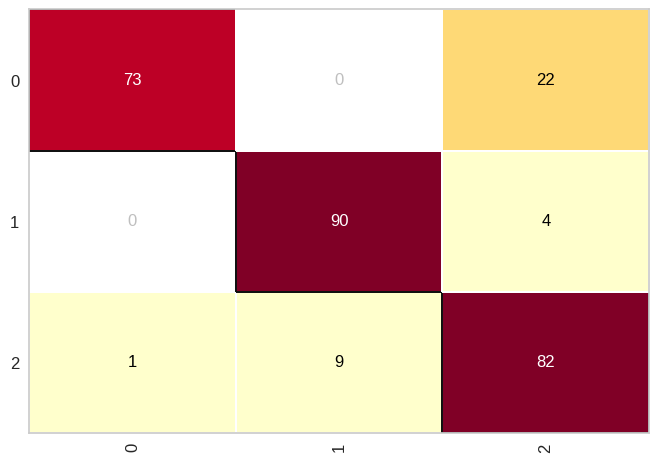

In [178]:
cm = ConfusionMatrix(decision_tree)
cm.fit(X_treino, y_treino_encoded)
cm.score(X_teste, y_teste_encoded)

In [179]:
print(classification_report(y_teste_encoded, previsoes_tree))

              precision    recall  f1-score   support

           0       0.99      0.77      0.86        95
           1       0.91      0.96      0.93        94
           2       0.76      0.89      0.82        92

    accuracy                           0.87       281
   macro avg       0.88      0.87      0.87       281
weighted avg       0.89      0.87      0.87       281



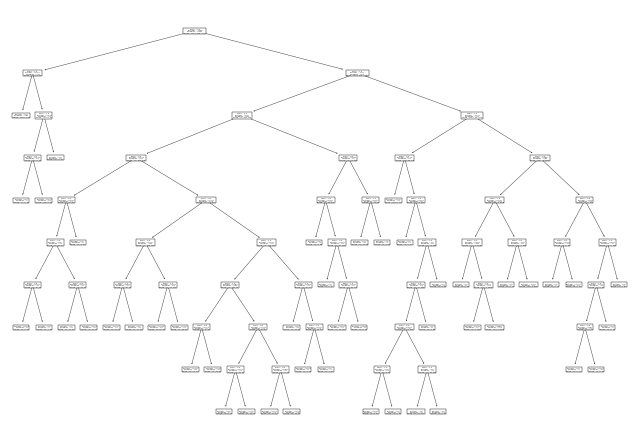

In [180]:
from sklearn import tree
plt.show(tree.plot_tree(decision_tree))